In [1]:
from scipy.sparse import coo_matrix, csr_matrix, save_npz, load_npz
import tensorcircuit as tc
from tensorcircuit import shadows
import jax
import jax.numpy as jnp
from jax import vmap
import time
from functools import partial, reduce
import pennylane as qml
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cirq
from jax.scipy.linalg import expm
from joblib import Parallel, delayed, parallel_backend
from pennylane import ClassicalShadow
import basefunction
import itertools,math


Please first ``pip install -U qiskit`` to enable related functionality in translation module


# 生成resultin,resultout数据集，其中resultin和线路参数在qubit_data.csv中

# 分别计算

In [ ]:


def prepare_initial_state(inistr: str, qubits):
    for i, char in enumerate(inistr):
        qml.StatePrep(state_vectors[int(char)], wires=qubits[i])

def ideal_circuit(rhoinput, params, qubits, obs_hamiltonian):
    dev = qml.device('default.qubit', wires=len(qubits))
    n_layers = params.shape[0]
    @jax.jit  
    @qml.qnode(dev, interface="jax")  
    def circuit():
        prepare_initial_state(rhoinput, qubits)  
        for layer in range(n_layers):
            for qubit in range(len(qubits)):
                qml.RX(params[layer, qubit, 0], wires=qubit)
                qml.RY(params[layer, qubit, 1], wires=qubit)
                qml.RZ(params[layer, qubit, 2], wires=qubit)
            for qubit in range(len(qubits) - 1):
                qml.CNOT(wires=[qubit, qubit + 1])    
        return qml.expval(obs_hamiltonian)     
    return circuit()

def ideal_circuit_d(rhoinput, params, qubits, obs_hamiltonian):
    dev = qml.device('default.qubit', wires=len(qubits))
    n_layers = params.shape[0]
    @jax.jit  
    @qml.qnode(dev, interface="jax")  
    def circuit():
        prepare_initial_state(rhoinput, qubits)  
        for layer in reversed(range(n_layers)):
            for qubit in reversed(range(len(qubits) - 1)):
                qml.CNOT(wires=[qubit, qubit + 1])
            for qubit in reversed(range(len(qubits))):
                qml.RZ(-params[layer, qubit, 2], wires=qubit)
                qml.RY(-params[layer, qubit, 1], wires=qubit)
                qml.RX(-params[layer, qubit, 0], wires=qubit)   
        return qml.expval(obs_hamiltonian)     
    return circuit()

def ideal_circuit_c(rhoinput, params, qubits, obs_hamiltonian):
    dev = qml.device('default.qubit', wires=len(qubits))
    n_layers = params.shape[0]
    @jax.jit  
    @qml.qnode(dev, interface="jax")  
    def circuit():
        prepare_initial_state(rhoinput, qubits)  
        for layer in range(n_layers):
            for qubit in range(len(qubits)):
                qml.RX(params[layer, qubit, 0], wires=qubit)
                qml.RY(params[layer, qubit, 1], wires=qubit)
                qml.RZ(params[layer, qubit, 2], wires=qubit)
            for qubit in range(len(qubits) - 1):
                qml.CNOT(wires=[qubit, qubit + 1])         
        for layer in range(n_layers):
            for qubit in range(len(qubits)):
                qml.RX(params[layer, qubit, 0], wires=qubit)
                qml.RY(params[layer, qubit, 1], wires=qubit)
                qml.RZ(params[layer, qubit, 2], wires=qubit)
            for qubit in range(len(qubits) - 1):
                qml.CNOT(wires=[qubit, qubit + 1])         
        return qml.expval(obs_hamiltonian)     
    return circuit()
def read_data():
    try:
        df = pd.read_csv('./input/qubit_data.csv')
        result_dict = {}
        for _, row in df.iterrows():
            num_qubits = row['num_qubits']
            rhoinput = np.array([int(x) for x in row['rhoinput'].split(',')])
            params_flat = np.array([float(x) for x in row['params'].split(',')])
            params = params_flat.reshape(10, num_qubits, 3)
            result_dict[num_qubits] = {'rhoinput': rhoinput, 'params': params}
        return result_dict
    except FileNotFoundError:
        print("error")
        return None
def calculate_performance(resultin, resultout):
    transition_matrix = basefunction.build_coo_matrix(np.array(resultin), np.array(resultout))
    
    tim3_3 = time.time()
    rhoin_p = jnp.array(resultin)

    rhoout_p0 = jax.vmap(basefunction.optimized_compute_multi_trace_stab2, in_axes=(0, None))(O_terms, resultout)
    rhoout_p1 = jax.vmap(lambda x, c: x * c)(rhoout_p0, jnp.array(coeffs))
    rhoout_p = jnp.sum(rhoout_p1, axis=0)
    
    tim3 = time.time()

    def process_item(P):
        prhoin_p = basefunction.optimized_compute_multi_trace(P, rhoin_p)
        results = prhoin_p * rhoout_p
        xp = jnp.mean(results)
        betap = (1/3) ** basefunction.count_non_I(P)
        alphap = basefunction.calculate_alpha_p(xp, betap, tilde_epsilon, eta)
        return alphap
    
    alphap_list = jax.vmap(process_item)(all_pauli).astype(jnp.float32)
    
    prho_p = basefunction.optimized_compute_multi_trace(all_pauli, rhoinput)
    results = prho_p * alphap_list
    positive_result = jnp.sum(results).astype(jnp.float32)

    daggertransition_matrix = basefunction.normalize_coo_matrix(transition_matrix.transpose())
    
    rhoin_d = jnp.array(sorted({tuple(s) for s in np.array(resultin)}))
    expvals_d0 = jax.vmap(basefunction.optimized_compute_multi_trace_stab2, in_axes=(0, None))(O_terms, rhoin_d)
    expvals_d1 = jax.vmap(lambda x, c: x * c)(expvals_d0, jnp.array(coeffs))
    expvals_d = jnp.sum(expvals_d1, axis=0)

    rhoout_d = daggertransition_matrix @ expvals_d
    rhoin_d = jnp.array(sorted({tuple(s) for s in np.array(resultout)}))
    
    @jax.jit
    def compute_xp_betap_alphap(P):
        prhoin_d = basefunction.optimized_compute_multi_trace(P, rhoin_d)
        results = prhoin_d * rhoout_d
        xp = jnp.mean(results)
        betap = (1/3) ** basefunction.count_non_I(P)
        alphap = basefunction.calculate_alpha_p(xp, betap, tilde_epsilon, eta)
        return alphap

    alphap_list = jax.vmap(compute_xp_betap_alphap)(all_pauli).astype(jnp.float32)
    results = prho_p * alphap_list
    dagger_result = jnp.sum(results).item()

    t2 = time.time()
    rhoin_d = jnp.array(sorted({tuple(s) for s in np.array(resultout)}))
    rhoin_c0 = rhoin_d
    expvals_c1 = jax.vmap(basefunction.optimized_compute_multi_trace_stab2, in_axes=(0, None))(O_terms, rhoin_c0)
    expvals_c2 = jax.vmap(lambda x, c: x * c)(expvals_c1, jnp.array(coeffs))
    expvals_c = jnp.sum(expvals_c2, axis=0)

    transition_matrix = basefunction.normalize_coo_matrix(transition_matrix)
    sigma_a_sub = basefunction.construct_sparse_matrix(resultout, resultin, num_qubits)

    rhoout_c = transition_matrix @ sigma_a_sub @ transition_matrix @ expvals_c
    del sigma_a_sub, transition_matrix

    rhoin_c = jnp.array(sorted({tuple(s) for s in np.array(resultin)}))

    def compute_xp_betap_alphap_c(P):
        prhoin_c = basefunction.optimized_compute_multi_trace(P, rhoin_c)
        results = prhoin_c * rhoout_c
        xp = jnp.mean(jnp.array(results))
        betap = (1/3) ** basefunction.count_non_I(P)
        alphap = basefunction.calculate_alpha_p(xp, betap, tilde_epsilon, eta).astype(jnp.float32)
        return alphap
    
    alphap_list = jax.vmap(compute_xp_betap_alphap_c)(all_pauli).astype(jnp.float32)
    results = prho_p * jnp.array(alphap_list)
    composition_result = jnp.sum(results).item()

    return positive_result, dagger_result, composition_result
from tqdm import tqdm
import os
if __name__ == "__main__":
    jax.config.update("jax_enable_x64", True)
    data = read_data()
    filename = f'process_shadows_results.csv'
    for num_qubits in [2, 4, 6, 8]:
        coeffs, terms = basefunction.calculate_observable(num_qubits, 0.27, 0.42, 0.76, 0.6, 0.4)
        O_terms = jnp.array(basefunction.convert_terms(terms, num_qubits))
        kappa = 2
        d = 7
        epsilon = 0.4
        delta = 0.01
        eta = sum(map(abs, coeffs))
        k=4
        tilde_epsilon = epsilon / (9 * 2 **(k + 1) * num_qubits** k) * ((basefunction.cal_C_k_d(kappa, d) / 3) **2)
        observation = qml.Hamiltonian(coeffs, terms)
        all_pauli = basefunction.generate_pauli(num_qubits, k)
        
        resultin_list, resultout_list = basefunction.load_results(num_qubits,f"./shadows/{num_qubits}qubits_performance_shadows.csv")
        jax.config.update("jax_enable_x64", True)
        rhoinput = data[num_qubits]["rhoinput"]
        params = data[num_qubits]["params"]
        
        sample_sizes = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
        
        
        num_runs = 50
        results = []
        qubits = [i for i in range(num_qubits)]
        ideal_tr_p = ideal_circuit(rhoinput, params, qubits, observation).item()
        ideal_tr_d = ideal_circuit_d(rhoinput, params, qubits, observation).item()
        ideal_tr_c = ideal_circuit_c(rhoinput, params, qubits, observation).item()
        
       
        
        if not os.path.exists(filename):
        pd.DataFrame(columns=[
            'num_qubits', 'N', 'positive_rmse', 'dagger_rmse', 'composition_rmse'
        ]).to_csv(filename, index=False)

        all_results = []

        for i, N in tqdm(enumerate(sample_sizes), total=len(sample_sizes), desc="Processing sample sizes"):
            positive_rmse_values = []
            dagger_rmse_values = []
            composition_rmse_values = []
            for times in range(num_runs):
                resultin = resultin_list[times][:N]
                resultout = resultout_list[times][:N]
                positive_result, dagger_result, composition_result = Dcalculate_process(resultin, resultout)
                positive_rmse = np.sqrt(np.mean((positive_result - ideal_tr_p) **2))
                dagger_rmse = np.sqrt(np.mean((dagger_result - ideal_tr_d)** 2))
                composition_rmse = np.sqrt(np.mean((composition_result - ideal_tr_c) **2))
                positive_rmse_values.append(positive_rmse)
                dagger_rmse_values.append(dagger_rmse)
                composition_rmse_values.append(composition_rmse)
            avg_positive_rmse = np.mean(positive_rmse_values)
            avg_dagger_rmse = np.mean(dagger_rmse_values)
            avg_composition_rmse = np.mean(composition_rmse_values)
            all_results.append({
                'num_qubits': num_qubits,  
                'N': N,
                'positive_rmse': avg_positive_rmse,
                'dagger_rmse': avg_dagger_rmse,
                'composition_rmse': avg_composition_rmse
            })
            pd.DataFrame(all_results).to_csv(filename, index=False, float_format='%.6f')
        final_df = pd.read_csv(filename)

# QPT代码

In [ ]:
Pauli_list = {
    6: np.array([[1, 0], [0, 1]]),
    7: np.array([[0, 1], [1, 0]]),
    8: np.array([[0, -1j], [1j, 0]]),
    9: np.array([[1, 0], [0, -1]])
}

stab1 = {
    0: np.array([[1, 0], [0, 0]]),
    1: np.array([[0, 0], [0, 1]]),
    2: 0.5 * np.array([[1, 1], [1, 1]]),
    3: 0.5 * np.array([[1, -1], [-1, 1]]),
    4: 0.5 * np.array([[1, -1j], [1j, 1]]),
    5: 0.5 * np.array([[1, 1j], [-1j, 1]]),
}

def str2rho(qubit_states):
    multi_qubit_rho = np.array([[1.0]])
    for state in qubit_states:
        if state in stab1:
            single_rho = stab1[state]
        elif state in Pauli_list:
            single_rho = Pauli_list[state]
        else:
            raise ValueError(f"Invalid state {state}. Must be between 0-9.")
        multi_qubit_rho = np.kron(multi_qubit_rho, single_rho)
    return multi_qubit_rho


def prepare_initial_state3(bit_strings, qubits) -> cirq.Circuit:
    states = list(bit_strings)
    num_qubits = len(states)
    circuit = cirq.Circuit()
    for i in range(num_qubits):
        circuit.append(cirq.I(qubits[i]))
    for i, state in enumerate(states):
        if state == 0:
            pass
        elif state == 1:
            circuit.append(cirq.X(qubits[i]))
        elif state == 2:
            circuit.append(cirq.H(qubits[i]))
        elif state == 3:
            circuit.append(cirq.X(qubits[i]))
            circuit.append(cirq.H(qubits[i]))
        elif state == 4:
            circuit.append(cirq.X(qubits[i]))
            circuit.append(cirq.H(qubits[i]))
            circuit.append(cirq.S(qubits[i])**-1)
        elif state == 5:
            circuit.append(cirq.H(qubits[i]))
            circuit.append(cirq.S(qubits[i])**-1)
        else:
            raise ValueError(f"Unknown state '{state}' for qubit {i}")
    return circuit

def quantum_process_dagger3(params, qubits, num_qubits, n_layers) -> cirq.Circuit:
    circuit = cirq.Circuit()
    for layer in range(n_layers):
        for qubit in range(num_qubits):
            circuit.append(cirq.rx(params[layer, qubit, 0]).on(qubits[qubit]))
            circuit.append(cirq.ry(params[layer, qubit, 1]).on(qubits[qubit]))
            circuit.append(cirq.rz(params[layer, qubit, 2]).on(qubits[qubit]))
        for qubit in range(num_qubits - 1):
            circuit.append(cirq.CNOT(qubits[qubit], qubits[qubit + 1]))
    return circuit

def test_circuit_dagger3(inistr: str, params, qubits, num_qubits, n_layers) -> cirq.Circuit:
    circuit: cirq.Circuit = prepare_initial_state3(inistr, qubits)
    return cirq.Circuit(list(circuit) + list(quantum_process_dagger3(params, qubits, num_qubits, n_layers)))

def vakey(num_qubits):
    combinations = itertools.product([0, 1, 2, 3, 4, 5], repeat=num_qubits)
    keys_list = [list(combination) for combination in combinations]
    return np.array(keys_list)

def calculate_T(A, B):
    A_stacked = np.vstack([mat.flatten() for mat in A])
    B_stacked = np.vstack([mat.flatten() for mat in B]).T
    B_inv = np.linalg.inv(B_stacked)
    return np.einsum('ij,jk->ik', A_stacked, B_inv)

def calrho3(U_matrix, rhoinput):
    return U_matrix @ rhoinput @ U_matrix.conj().T

def senary_to_integer(n):
    arrays = [np.array([0, 1, 2, 4]) for _ in range(n)]
    grid = np.meshgrid(*arrays, indexing='ij')
    senary_list = np.stack(grid, axis=-1).reshape(-1, n)
    powers = 6 ** np.arange(n)[::-1]
    return np.dot(senary_list, powers)

def QPT_cal(num_qubits, params, nshot, n_layers, rhoin_strings, se_matrices, beta_matrix, P_list, Umatrix, observation):
    if nshot == "infinite":
        rhoout_list = Parallel(n_jobs=-1)(
            delayed(lambda x: calrho3(Umatrix, x))(rho_in0) for rho_in0 in se_matrices
        )
    else:
        nshot = math.ceil(nshot / (3**num_qubits * 4**num_qubits))
        def process_rho_in0(rho_in0):
            qubits = cirq.LineQubit.range(num_qubits)
            simulator = cirq.Simulator()
            cir_q = test_circuit_dagger3(rho_in0, params, qubits, num_qubits, n_layers)
            rhoout = cirq.experiments.state_tomography(simulator, qubits, cir_q, nshot)
            return rhoout
        rhoout_list = Parallel(n_jobs=-1)(
            delayed(process_rho_in0)(rho_in0) for rho_in0 in rhoin_strings
        )
    
    decompisition_T = calculate_T(np.array(rhoout_list), np.array(se_matrices))
    b_vector = np.ravel(decompisition_T) if np.ndim(decompisition_T) > 1 else decompisition_T
    chiX = np.reshape(np.linalg.solve(beta_matrix.T, b_vector), (4**num_qubits, 4**num_qubits))
    eigenvalues, eigenvectors = np.linalg.eig(chiX)
    U = eigenvectors
    D = np.diag(eigenvalues)
    Kraus_list = np.einsum('md,dd,mij->dij', np.array(U), np.sqrt(np.array(D)), np.array(P_list))
    rho = str2rho(rhoinput)
    Erho = np.zeros((2**num_qubits, 2**num_qubits))
    for i in range(len(Kraus_list)):
        Erho = Erho + (Kraus_list[i]) @ rho @ (Kraus_list[i]).conj().T
    ideal_tr_1 = np.trace(observation @ calrho3(Umatrix, str2rho(rhoinput))).astype(np.float64)
    QPT_result_1 = np.trace(observation @ Erho).astype(np.float64)

    if nshot == "infinite":
        rhoout_list2 = Parallel(n_jobs=-1)(
            delayed(lambda x: calrho3(Umatrix, x))(rho_in0) for rho_in0 in se_matrices
        )
    else:
        nshot2 = math.ceil(nshot / (3**num_qubits * 4**num_qubits))
        def process_rho_in0(rho_in0):
            qubits = cirq.LineQubit.range(num_qubits)
            simulator = cirq.Simulator()
            cir_q = test_circuit_dagger3(rho_in0, params, qubits, num_qubits, n_layers)
            rhoout = cirq.experiments.state_tomography(simulator, qubits, cir_q, nshot2)
            return rhoout
        rhoout_list2 = Parallel(n_jobs=-1)(
            delayed(process_rho_in0)(rho_in0) for rho_in0 in rhoin_strings
        )
    
    decompisition_T2 = calculate_T(np.array(rhoout_list2), np.array(se_matrices))
    b_vector2 = np.ravel(decompisition_T2) if np.ndim(decompisition_T2) > 1 else decompisition_T2
    chiX2 = np.reshape(np.linalg.solve(beta_matrix.T, b_vector2), (4**num_qubits, 4**num_qubits))
    eigenvalues2, eigenvectors2 = np.linalg.eig(chiX2)
    U2 = eigenvectors2
    D2 = np.diag(eigenvalues2)
    Kraus_list2 = np.einsum('md,dd,mij->dij', np.array(U2), np.sqrt(np.array(D2)), np.array(P_list))

    rho = str2rho(rhoinput)
    Erho = np.zeros((2**num_qubits, 2**num_qubits))
    for i in range(len(Kraus_list)):
        for j in range(len(Kraus_list2)):
            Erho = Erho + (Kraus_list2[j] @ Kraus_list[i]) @ rho @ (Kraus_list[i] @ Kraus_list2[j]).conj().T
    ideal_tr_2 = np.trace(observation @ calrho3(Umatrix @ Umatrix, str2rho(rhoinput))).astype(np.float64)
    QPT_result_2 = np.trace(observation @ Erho).astype(np.float64)

    return QPT_result_1, ideal_tr_1, QPT_result_2, ideal_tr_2

data = read_data()

if __name__ == "__main__":
    filename = 'qpt_com_results.csv'
    for num_qubits in [2, 4]:
        rhoinput = data[num_qubits]["rhoinput"]
        params = data[num_qubits]["params"]
        dev = qml.device('default.qubit', wires=num_qubits)
        n_layers = 10
        
        @qml.qnode(dev)
        def quantum_circuit():
            for layer in range(n_layers):
                for qubit in range(num_qubits):
                    qml.RX(params[layer, qubit, 0], wires=qubit)
                    qml.RY(params[layer, qubit, 1], wires=qubit)
                    qml.RZ(params[layer, qubit, 2], wires=qubit)
                for qubit in range(num_qubits - 1):
                    qml.CNOT(wires=[qubit, qubit + 1])
            return qml.state()

        Umatrix = qml.matrix(quantum_circuit)()
        keys_list = vakey(num_qubits)
        coeffs, terms = basefunction.calculate_observable(num_qubits, 0.27, 0.42, 0.76, 0.6, 0.4)
        observation = qml.matrix(qml.Hamiltonian(coeffs, terms))
        all_pauli = [list(item) for item in itertools.product([6, 7, 8, 9], repeat=num_qubits)]

        P_list = Parallel(n_jobs=-1)(
            delayed(str2rho)(rho_in0) for rho_in0 in all_pauli)

        rhoin_strings = [keys_list[inds] for inds in senary_to_integer(num_qubits)]
        se_matrices = Parallel(n_jobs=-1)(
            delayed(str2rho)(rho_in0) for rho_in0 in rhoin_strings)
        E_rhoin_list = np.einsum('abc,dcf,ifk->aidbk', np.array(P_list), np.array(se_matrices), np.array(P_list)).reshape(4 **(3*num_qubits), 2**num_qubits, 2**num_qubits)
        beta_matrix = calculate_T(E_rhoin_list, np.array(se_matrices)).reshape(4 ** (2 * num_qubits), 4 ** (2 * num_qubits))

        num_runs = 50
        N_list = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
        

        if not os.path.exists(filename):
        pd.DataFrame(columns=[
            'num_qubits', 'N', 'QPT_single_rmse', 'QPT_com_rmse'
        ]).to_csv(filename, index=False)

        results = []
        for N in tqdm(N_list, desc="Processing sample sizes"):
            single_rmse_list = []
            com_rmse_list = []
            
            for times in range(num_runs):
                QPT_result_1, ideal_tr_1, QPT_result_2, ideal_tr_2 = Dcalculate_process(
                    num_qubits, params, N, n_layers, rhoin_strings, 
                    se_matrices, beta_matrix, P_list, Umatrix, observation
                )
                single_rmse = np.sqrt(np.mean((QPT_result_1 - ideal_tr_1) **2))
                com_rmse = np.sqrt(np.mean((QPT_result_2 - ideal_tr_2)** 2))
                single_rmse_list.append(single_rmse)
                com_rmse_list.append(com_rmse)
            avg_single_rmse = np.mean(single_rmse_list)
            avg_com_rmse = np.mean(com_rmse_list)
            results.append({
                'num_qubits': num_qubits,
                'N': N,
                'QPT_single_rmse': avg_single_rmse,
                'QPT_com_rmse': avg_com_rmse
            })
            pd.DataFrame(results).to_csv(filename, index=False)
            print(f"Saved results for N={N}")

        print(f"All results saved to {filename}")

In [ ]:
import pandas as pd
df1 = pd.read_csv('./data/process_shadows_results.csv')  # 替换为第一个文件的路径
df2 = pd.read_csv('./data/qpt_com_results.csv') # 替换为第二个文件的路径

columns_to_merge = [col for col in df2.columns if col not in ['num_qubits', 'N']]

# 使用左连接，保留第一个表的所有记录
merged_df = pd.merge(
    df1, 
    df2[['num_qubits', 'N'] + columns_to_merge], 
    on=['num_qubits', 'N'], 
    how='left'  # 左连接：保留第一个表的所有行
)

# 保存合并后的结果
merged_df.to_csv('./data/merged_results_with_all.csv', index=False)


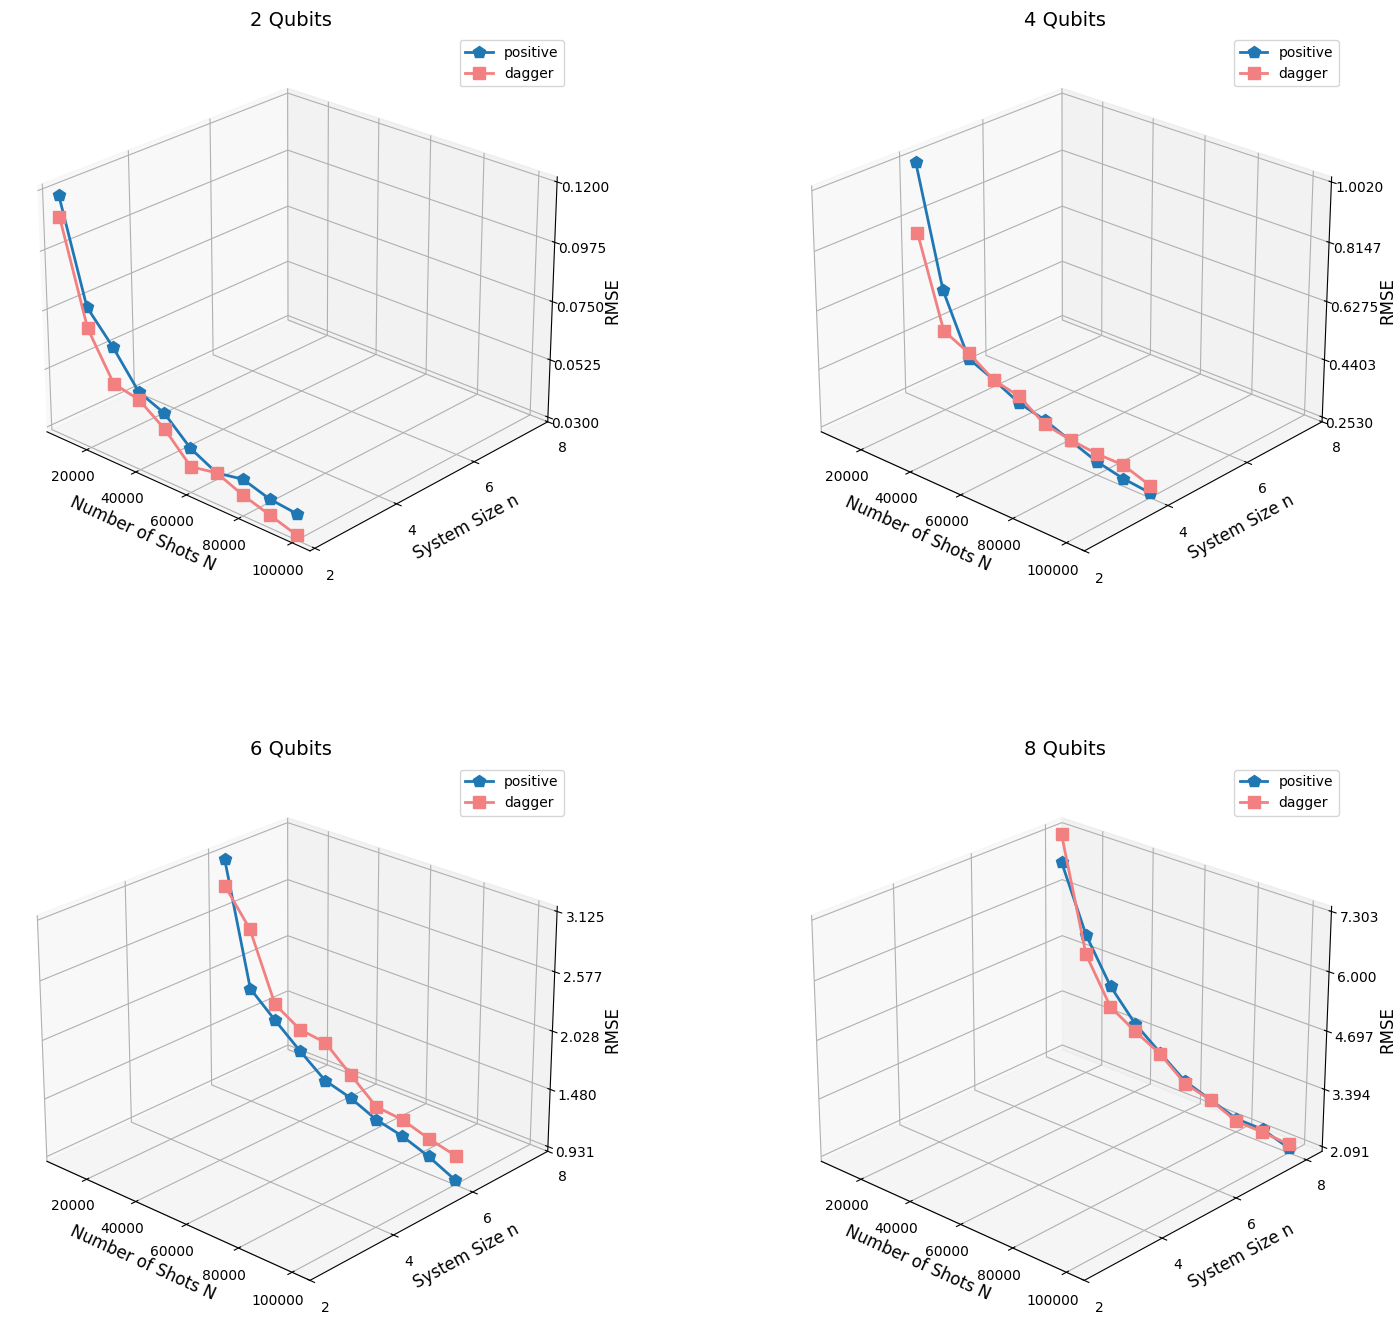

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


data = pd.read_csv('./data/merged_results_with_all.csv')
num_qubits_values = sorted(data['num_qubits'].unique())

style_map = {
    'positive_rmse': ('#1f77b4', 'p'),   
    'dagger_rmse'  : ('#F28080', 's'),   
}
lw = 2
ms = 9
x_ticks = [20000, 40000, 60000, 80000, 100000]

fig = plt.figure(figsize=(14, 14))

for i, nq in enumerate(num_qubits_values):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    subset = data[data['num_qubits'] == nq]
    N = subset['N']

    for method, (color, marker) in style_map.items():
        if method in subset.columns and not subset[method].isnull().all():
            # 添加图例标签，移除名称中的"_rmse"
            label = method.replace('_rmse', '')
            ax.plot(
                N, [nq] * len(N), subset[method],
                label=label,
                color=color,
                marker=marker,
                markersize=ms,
                linewidth=lw
            )
    
    ax.set_xticks(x_ticks)
    ax.set_yticks(num_qubits_values)
    z_min = subset[list(style_map.keys())].min().min()
    z_max = subset[list(style_map.keys())].max().max()
    z_ticks = np.linspace(z_min, z_max, 5)
    ax.set_zticks(z_ticks)
    ax.set_xlabel('Number of Shots N', fontsize=12)
    ax.set_ylabel('System Size n', fontsize=12)
    ax.set_zlabel('RMSE', fontsize=12, rotation=90)
    ax.set_title(f'{nq} Qubits', fontsize=14) 
    
    ax.view_init(elev=25, azim=-47.5)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', length=5, width=1, labelsize=10)
    
    ax.legend(fontsize=10)


plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.subplots_adjust(wspace=0.3, hspace=0.3)  

plt.savefig('fig2(a).svg',
            format='svg',
            bbox_inches='tight',
            transparent=True)
plt.show()
plt.close()


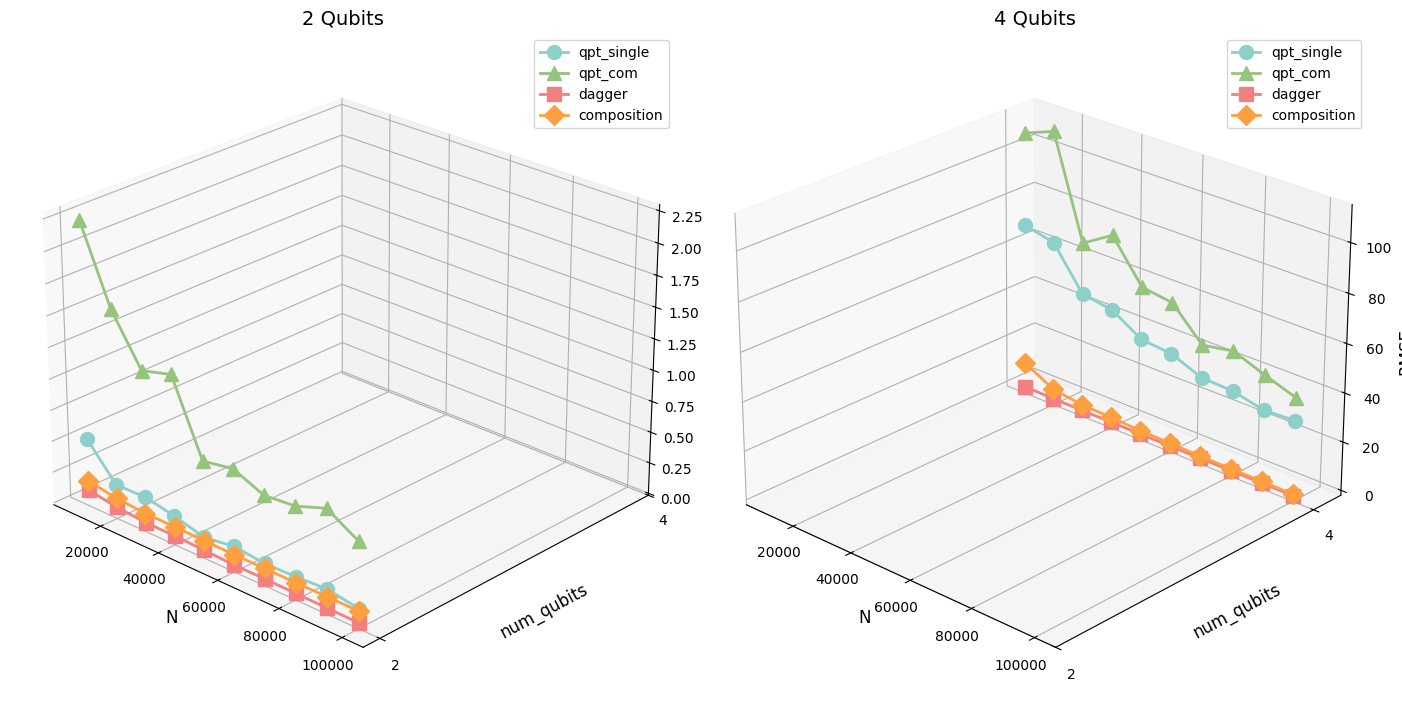

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

data = pd.read_csv('./data/merged_results_with_all.csv')

fig = plt.figure(figsize=(14, 14))

num_qubits_values = sorted(data['num_qubits'].unique()[:2])


color_map = {
    'qpt_single_rmse'        : '#8ecfc9',
    'qpt_com_rmse'    : '#96c37d',
    'dagger_rmse'     : '#F28080',
    'composition_rmse': '#fea040'
}

marker_map = {
    'qpt_single_rmse'        : 'o', 
    'qpt_com_rmse'    : '^',   
    'dagger_rmse'     : 's',  
    'composition_rmse': 'D'    
}


lw = 2
ms = 10

for i, nq in enumerate(num_qubits_values):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    subset = data[data['num_qubits'] == nq]
    N = subset['N']

    for method in color_map.keys():
        if method in subset.columns and not subset[method].isnull().all():
            ax.plot(N,
                    [nq] * len(N),
                    subset[method],
                    label=method.replace('_rmse', ''),
                    color=color_map[method],
                    marker=marker_map[method],
                    markersize=ms,
                    linewidth=lw)

    ax.set_xlabel('N', fontsize=12)
    ax.set_ylabel('num_qubits', fontsize=12)
    ax.set_zlabel('RMSE', fontsize=12, rotation=90)
    ax.set_title(f'{nq} Qubits', fontsize=14)
    ax.set_yticks(num_qubits_values)
    ax.view_init(elev=25, azim=-47)
    ax.legend(fontsize=10)
    ax.grid(True)

plt.tight_layout()
plt.savefig('fig2(b).svg', format='svg', bbox_inches='tight')
plt.show()